doc: https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2013-2017.pdf?fbclid=IwAR1yvvDS-8yfSKGV77mPkHlwdb8FIGD80Zd4h7xPude0SDw6--X4HNxTeNo

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

/Users/littletree/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### read data

In [2]:
df_a = pd.read_csv("csv_hus/psam_husa.csv")
# print(list(df_a))

In [3]:
df_b = pd.read_csv("csv_hus/psam_husb.csv")
# print(list(df_b))

In [4]:
df_c = pd.read_csv("csv_hus/psam_husc.csv")
# print(list(df_c))

In [5]:
df_d = pd.read_csv("csv_hus/psam_husd.csv")
df_d.head()
print(list(df_d))

['RT', 'SERIALNO', 'DIVISION', 'PUMA', 'REGION', 'ST', 'ADJHSG', 'ADJINC', 'WGTP', 'NP', 'TYPE', 'ACCESS', 'ACR', 'AGS', 'BATH', 'BDSP', 'BLD', 'BUS', 'BROADBND', 'COMPOTHX', 'CONP', 'DIALUP', 'ELEP', 'FS', 'FULP', 'GASP', 'HFL', 'HISPEED', 'HOTWAT', 'INSP', 'LAPTOP', 'MHP', 'MRGI', 'MRGP', 'MRGT', 'MRGX', 'OTHSVCEX', 'REFR', 'RMSP', 'RNTM', 'RNTP', 'RWAT', 'RWATPR', 'SATELLITE', 'SINK', 'SMARTPHONE', 'SMP', 'STOV', 'TABLET', 'TEL', 'TEN', 'TOIL', 'VACS', 'VALP', 'VEH', 'WATP', 'YBL', 'FES', 'FINCP', 'FPARC', 'GRNTP', 'GRPIP', 'HHL', 'HHT', 'HINCP', 'HUGCL', 'HUPAC', 'HUPAOC', 'HUPARC', 'KIT', 'LNGI', 'MULTG', 'MV', 'NOC', 'NPF', 'NPP', 'NR', 'NRC', 'OCPIP', 'PARTNER', 'PLM', 'PLMPRP', 'PSF', 'R18', 'R60', 'R65', 'RESMODE', 'SMOCP', 'SMX', 'SRNT', 'SSMC', 'SVAL', 'TAXP', 'WIF', 'WKEXREL', 'WORKSTAT', 'FACCESSP', 'FACRP', 'FAGSP', 'FBATHP', 'FBDSP', 'FBLDP', 'FBROADBNDP', 'FCOMPOTHXP', 'FBUSP', 'FCONP', 'FDIALUPP', 'FELEP', 'FFINCP', 'FFSP', 'FFULP', 'FGASP', 'FGRNTP', 'FHFLP', 'FHINCP'

In [7]:
# cal n
print('n =', df_a.shape[0] + df_b.shape[0] + df_c.shape[0] + df_d.shape[0])
# concat dfs
df = pd.concat([df_a, df_b, df_c, df_d])
print('shape =', df.shape)
# check unique
df['SERIALNO'].nunique()

n= 7487361
shape= (7487361, 233)


7487361

### feature selection
#### to_use : <br>
ST - State code based on 2010 Census definitions,<br> 
ADJINC - Adjustment factor for income and earnings dollar amounts (6 implied decimal places),<br> 
NP - Number of persons associated with this housing record,<br> 
FES - Family type and employment status,<br> 
FINCP - Family income (past 12 months, use ADJINC to adjust FINCP to constant dollars),<br> 
NRC - Number of related children in household (unweighted),<br> 
OCPIP - Selected monthly owner costs as a percentage of household income during the past 12 months <br>
#### y : <br>
FS - Yearly food stamp/Supplemental Nutrition Assistance Program (SNAP) recipiency, <br>
FFSP - Yearly food stamp/Supplemental Nutrition Assistance Program (SNAP) recipiency allocation flag<br>
#### optional : <br>
VEH, yearly ex(FULP, GASP, HFL, INSP, MHP, RNTPx12, SMPx12, WATP), TAXP, WORKSTAT, AGEP <br>

### possible targets
#### HINS4 (x)
Medicaid, Medical Assistance, or any kind of government-assistance plan for those with low incomes or a disability<br>
1 .Yes<br> 
2 .No<br>
#### FHINS4P (x)
Medicaid, medical assistance, or any kind of government-assistance plan for people with low incomes or a disability allocation flag<br>
0 .No<br>
1 .Yes<br>
#### FS (v)
Yearly food stamp/Supplemental Nutrition Assistance Program (SNAP) recipiency<br>
b .N/A (vacant)<br>
1 .Yes<br>
2 .No<br>
#### FFSP (v)
Yearly food stamp/Supplemental Nutrition Assistance Program (SNAP) recipiency allocation flag<br>
0 .No<br> 
1 .Yes<br>
#### FPAP (x)
Public assistance income allocation flag<br>
0 .No<br>
1 .Yes<br>

### exploratory data analysis

In [8]:
pd.pivot_table(df, values=['ADJINC', 'FINCP'], index=['FS', 'FFSP'], aggfunc=[np.min, np.mean, np.max])

amin                   mean                    amax           
           ADJINC    FINCP        ADJINC          FINCP   ADJINC      FINCP
FS  FFSP                                                                   
1.0 0     1011189 -16400.0  1.037457e+06   35913.090197  1061971  3164000.0
    1     1011189  -5400.0  1.036512e+06   42653.214567  1061971   683400.0
2.0 0     1011189 -21500.0  1.036483e+06  102542.590238  1061971  2186200.0
    1     1011189  -5800.0  1.035597e+06   86245.091037  1061971  1331000.0

In [9]:
df[df["FS"]==1]["FINCP"].describe() # FS_y

count    4.805550e+05
mean     3.603788e+04
std      4.219986e+04
min     -1.640000e+04
25%      1.300000e+04
50%      2.460000e+04
75%      4.500000e+04
max      3.164000e+06
Name: FINCP, dtype: float64

In [10]:
df[df["FS"]==2]["FINCP"].describe() #FS_n

count    3.604400e+06
mean     1.022982e+05
std      9.784668e+04
min     -2.150000e+04
25%      4.590000e+04
50%      7.700000e+04
75%      1.235000e+05
max      2.186200e+06
Name: FINCP, dtype: float64

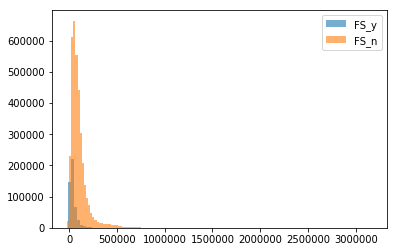

In [11]:
plt.hist(df[df["FS"]==1]["FINCP"].dropna(), bins=100, alpha=0.6, label="FS_y")
plt.hist(df[df["FS"]==2]["FINCP"].dropna(), bins=100, alpha=0.6, label="FS_n")
plt.legend()
plt.show()

In [12]:
df[df["FS"]==1]["HINCP"].describe() # FS_y

count    7.076720e+05
mean     3.228250e+04
std      4.058255e+04
min     -1.640000e+04
25%      1.020000e+04
50%      2.000000e+04
75%      4.000000e+04
max      3.209000e+06
Name: HINCP, dtype: float64

In [13]:
df[df["FS"]==2]["HINCP"].describe() #FS_n

count    5.424552e+06
mean     8.661534e+04
std      9.070665e+04
min     -2.150000e+04
25%      3.390000e+04
50%      6.267000e+04
75%      1.070000e+05
max      2.186200e+06
Name: HINCP, dtype: float64

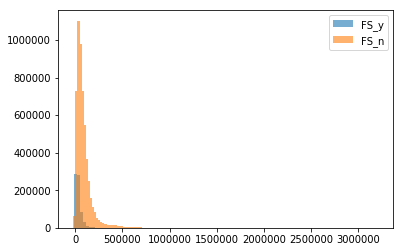

In [14]:
plt.hist(df[df["FS"]==1]["HINCP"].dropna(), bins=100, alpha=0.6, label="FS_y")
plt.hist(df[df["FS"]==2]["HINCP"].dropna(), bins=100, alpha=0.6, label="FS_n")
plt.legend()
plt.show()

### preprocessing

In [15]:
to_use = ['ST', 'ADJINC', 'NP', 'FES', 'FINCP', 'NRC', 'OCPIP', 'FS', 'FFSP']
# y : FS, FFSP
# check whether variables exist
[i for i in list(df_a) if i in to_use]

['ST', 'ADJINC', 'NP', 'FS', 'FES', 'FINCP', 'NRC', 'OCPIP', 'FFSP']

In [16]:
# drop na
data = df[to_use]
data_rna = df[to_use].dropna(axis=0, how='any')
print(data.shape, data_rna.shape)
data_rna.head()

(7487361, 9) (3096756, 9)


,ST,ADJINC,NP,FES,FINCP,NRC,OCPIP,FS,FFSP
1,1,1061971,4,1.0,151000.0,0.0,3.0,2.0,0
6,1,1061971,2,1.0,136000.0,0.0,13.0,2.0,0
7,1,1061971,2,4.0,52600.0,0.0,8.0,2.0,0
9,1,1061971,2,1.0,81600.0,0.0,13.0,2.0,0
14,1,1061971,2,1.0,35000.0,0.0,10.0,2.0,0


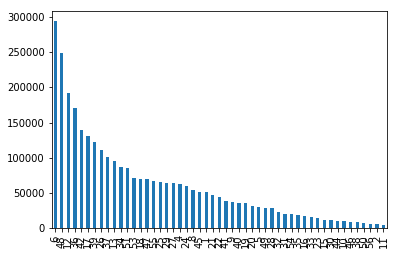

In [37]:
data_rna['ST'].value_counts().plot.bar()

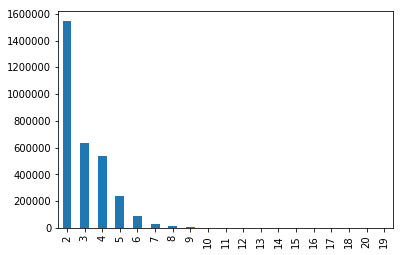

In [40]:
data_rna['NP'].value_counts().plot.bar()

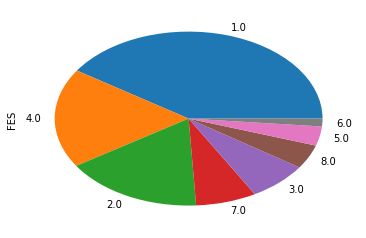

In [45]:
data_rna['FES'].value_counts().plot.pie()

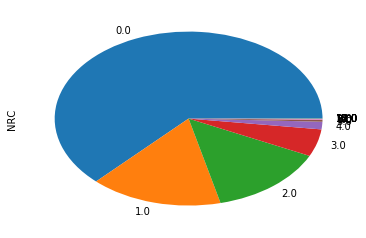

In [46]:
data_rna['NRC'].value_counts().plot.pie()

### one-hot encoding

In [88]:
df_oh = data_rna.copy()
df_oh = pd.get_dummies(df_oh, columns=['ST'], prefix = ['ST'])
df_oh = pd.get_dummies(df_oh, columns=['ADJINC'], prefix = ['ADJINC'])
df_oh = pd.get_dummies(df_oh, columns=['FES'], prefix = ['FES'])
df_oh['FS'].replace([1.0, 2.0], [1, 0], inplace=True)
df_oh.head()

,NP,FINCP,NRC,OCPIP,FS,FFSP,ST_1,ST_2,ST_4,ST_5,...,ADJINC_1045195,ADJINC_1061971,FES_1.0,FES_2.0,FES_3.0,FES_4.0,FES_5.0,FES_6.0,FES_7.0,FES_8.0
1,4,151000.0,0.0,3.0,0.0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0
6,2,136000.0,0.0,13.0,0.0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0
7,2,52600.0,0.0,8.0,0.0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
9,2,81600.0,0.0,13.0,0.0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0
14,2,35000.0,0.0,10.0,0.0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [79]:
print(list(df_oh))

['NP', 'FINCP', 'NRC', 'OCPIP', 'FS', 'FFSP', 'ST_1', 'ST_2', 'ST_4', 'ST_5', 'ST_6', 'ST_8', 'ST_9', 'ST_10', 'ST_11', 'ST_12', 'ST_13', 'ST_15', 'ST_16', 'ST_17', 'ST_18', 'ST_19', 'ST_20', 'ST_21', 'ST_22', 'ST_23', 'ST_24', 'ST_25', 'ST_26', 'ST_27', 'ST_28', 'ST_29', 'ST_30', 'ST_31', 'ST_32', 'ST_33', 'ST_34', 'ST_35', 'ST_36', 'ST_37', 'ST_38', 'ST_39', 'ST_40', 'ST_41', 'ST_42', 'ST_44', 'ST_45', 'ST_46', 'ST_47', 'ST_48', 'ST_49', 'ST_50', 'ST_51', 'ST_53', 'ST_54', 'ST_55', 'ST_56', 'ADJINC_1011189', 'ADJINC_1029257', 'ADJINC_1035988', 'ADJINC_1045195', 'ADJINC_1061971', 'FES_1.0', 'FES_2.0', 'FES_3.0', 'FES_4.0', 'FES_5.0', 'FES_6.0', 'FES_7.0', 'FES_8.0']


### logistic regression (skipped)

In [89]:
# separate X and Y
X = df_oh.copy().drop(['FS', 'FFSP'], axis=1, inplace=False)
Y_FS = df_oh.FS
Y_FFSP = df_oh.FFSP

In [90]:
# model fitting
test_size = 0.33
seed = 7
X_train, X_test, Y_FS_train, Y_FS_test = train_test_split(X, Y_FS, test_size=test_size, random_state=seed)

model_FS = LogisticRegression()
model_FS.fit(X_train, Y_FS_train)
# result_FS = model_FS.score(X_test, Y_FS_test)
print(model_FS.coef_)

[[ 5.23908346e-03 -3.63590563e-05  4.24667051e-03 -1.12842354e-02
  -4.04437245e-05  1.45318065e-05 -5.33213222e-06 -3.92217492e-05
  -1.28239070e-04 -5.58647580e-05 -8.02503495e-06  1.33767699e-06
   6.60797116e-06  9.46928085e-06 -1.24746440e-05  1.23843725e-05
  -2.49951130e-05 -1.45341467e-05 -8.88816723e-05 -3.97676475e-05
  -5.15228686e-05 -3.29760974e-05 -1.16645182e-05 -5.92011991e-06
   2.55018541e-05 -1.55363343e-05 -3.22808494e-05 -9.92635757e-05
  -3.72768150e-06 -7.59229308e-05 -1.96069628e-05 -3.64936977e-05
  -1.73231072e-05 -1.60405376e-05 -3.43219799e-05  1.47570455e-05
  -1.17209952e-05 -5.93002841e-05 -1.70409696e-05 -8.86846940e-05
  -2.32123339e-05  1.89647047e-05 -1.09285131e-04  1.00870122e-06
  -2.51423692e-05 -1.43116027e-05 -2.42765726e-05 -3.79004728e-05
  -3.42164275e-05 -4.21727034e-06 -5.34733634e-05  1.21935312e-05
  -9.92581736e-06 -8.40801541e-05 -1.04237351e-05 -3.05211924e-04
  -2.71493287e-04 -2.70039554e-04 -2.85769819e-04 -2.68321619e-04
  -4.71767

In [91]:
# confusion matrix
Y_FS_pred=model_FS.predict(X_test)

cnf_FS_matrix = metrics.confusion_matrix(Y_FS_test, Y_FS_pred)
cnf_FS_matrix

array([[957891,      4],
       [ 64032,      3]])

Text(0.5,257.44,'Predicted label')

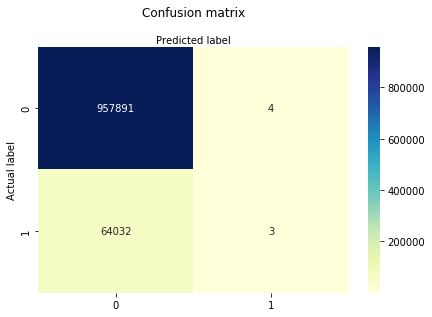

In [92]:
# visualize confusion matrix
class_names=['1','2'] # name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_FS_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [93]:
print("Accuracy:",metrics.accuracy_score(Y_FS_test, Y_FS_pred))
print("Precision:",metrics.precision_score(Y_FS_test, Y_FS_pred))
print("Recall:",metrics.recall_score(Y_FS_test, Y_FS_pred))

Accuracy: 0.9373381738475238
Precision: 0.42857142857142855
Recall: 4.684937924572499e-05


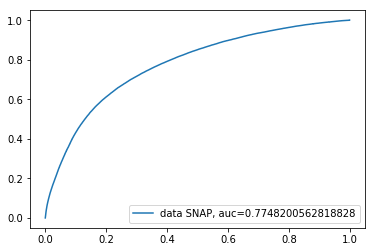

In [95]:
Y_FS_pred_proba = model_FS.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_FS_test, Y_FS_pred_proba)
auc = metrics.roc_auc_score(Y_FS_test, Y_FS_pred_proba)
plt.plot(fpr,tpr,label="data SNAP, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### logistic regression - deal with unbalanced data by sampling 

In [117]:
df_oh_FS_0 = df_oh[df_oh['FS'] == 0].sample(n=df_oh['FS'].value_counts()[1], random_state=1)
df_oh_FS_1 = df_oh[df_oh['FS'] == 1]
balanced_df_oh = pd.concat([df_oh_FS_0, df_oh_FS_1])
# separate X and Y
balanced_X = balanced_df_oh.copy().drop(['FS', 'FFSP'], axis=1, inplace=False)
balanced_Y_FS = balanced_df_oh.FS
balanced_Y_FFSP = balanced_df_oh.FFSP

In [120]:
# model fitting
test_size = 0.33
seed = 7
balanced_X_train, balanced_X_test, balanced_Y_FS_train, balanced_Y_FS_test = train_test_split(balanced_X, balanced_Y_FS, test_size=test_size, random_state=seed)

balanced_model_FS = LogisticRegression()
balanced_model_FS.fit(balanced_X_train, balanced_Y_FS_train)
# result_FS = model_FS.score(X_test, Y_FS_test)
print(balanced_model_FS.coef_)

[[ 3.09879791e-02 -1.04786229e-05  1.26656088e-02  2.20171394e-02
   1.06380702e-04  5.58886248e-05  1.88922996e-04  5.68911361e-05
  -1.80987581e-04 -1.01359230e-04 -4.32435537e-05  2.22340389e-05
   2.07304185e-05  5.35637529e-04  1.96951374e-04  4.50639255e-05
  -9.17588180e-06  1.19144559e-04  6.43155164e-06 -7.72422693e-06
  -4.09621783e-05  9.23778474e-05  1.48902807e-04  3.10997784e-05
   6.11608615e-05 -4.75425202e-05  2.21857454e-04 -1.68066113e-04
   1.41192112e-04  3.88572046e-06 -8.64351368e-06 -4.27558632e-05
   7.16770991e-06 -3.51047150e-05 -1.73262984e-04  1.39143378e-04
   7.49394952e-05  1.19893684e-04 -2.28385724e-05  7.80896147e-05
   8.99525517e-05  1.32763837e-04  3.24572156e-05 -3.88797025e-07
   1.16722464e-04 -9.85189137e-06  1.97980621e-04  6.02603942e-04
  -4.51789526e-05 -4.22741381e-06 -5.92097405e-05  1.25857132e-04
   8.77032111e-05 -8.86674320e-05 -1.37777728e-05  4.19741029e-04
   5.45180210e-04  5.24366301e-04  5.60962163e-04  7.06809658e-04
  -2.01985

In [121]:
# confusion matrix
balanced_Y_FS_pred=balanced_model_FS.predict(balanced_X_test)

balanced_cnf_FS_matrix = metrics.confusion_matrix(balanced_Y_FS_test, balanced_Y_FS_pred)
balanced_cnf_FS_matrix

array([[47784, 16403],
       [21744, 42351]])

In [122]:
print("Accuracy:",metrics.accuracy_score(balanced_Y_FS_test, balanced_Y_FS_pred))
print("Precision:",metrics.precision_score(balanced_Y_FS_test, balanced_Y_FS_pred))
print("Recall:",metrics.recall_score(balanced_Y_FS_test, balanced_Y_FS_pred))

Accuracy: 0.702631702031462
Precision: 0.7208190080675358
Recall: 0.6607535689211327


### random forest (skipped)

In [125]:
#Create a Gaussian Classifier
clf_FS=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_FS.fit(X_train,Y_FS_train)

rf_Y_FS_pred=clf_FS.predict(X_test)

In [131]:
print("Accuracy:",metrics.accuracy_score(Y_FS_test, rf_Y_FS_pred))
print("Precision:",metrics.precision_score(Y_FS_test, rf_Y_FS_pred))
print("Recall:",metrics.recall_score(Y_FS_test, rf_Y_FS_pred))

Accuracy: 0.9351198222970262
Precision: 0.45674397314617027
Recall: 0.18699148902943702


In [130]:
# get feature importance scores (sum to 1)
feature_imp = pd.Series(clf_FS.feature_importances_,index=list(X)).sort_values(ascending=False)
feature_imp

FINCP             0.398398
OCPIP             0.211158
NP                0.074719
NRC               0.044400
FES_8.0           0.021763
ADJINC_1035988    0.012126
ADJINC_1045195    0.012086
ADJINC_1029257    0.011945
ADJINC_1061971    0.011285
ADJINC_1011189    0.010567
FES_7.0           0.010015
FES_1.0           0.009223
ST_48             0.006860
ST_17             0.005993
FES_4.0           0.005975
ST_42             0.005871
ST_36             0.005453
ST_37             0.005322
ST_12             0.005297
ST_39             0.005264
ST_6              0.005183
ST_13             0.005175
FES_2.0           0.005078
ST_26             0.004919
FES_6.0           0.004550
ST_4              0.004203
ST_29             0.003987
ST_47             0.003982
ST_53             0.003952
ST_18             0.003885
                    ...   
FES_5.0           0.003064
FES_3.0           0.002910
ST_5              0.002854
ST_41             0.002826
ST_28             0.002797
ST_19             0.002472
S

### random forest - deal with unbalanced data by sampling

In [132]:
#Create a Gaussian Classifier
balanced_clf_FS=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
balanced_clf_FS.fit(balanced_X_train, balanced_Y_FS_train)

balanced_rf_Y_FS_pred=balanced_clf_FS.predict(balanced_X_test)

In [133]:
print("Accuracy:",metrics.accuracy_score(balanced_Y_FS_test, balanced_rf_Y_FS_pred))
print("Precision:",metrics.precision_score(balanced_Y_FS_test, balanced_rf_Y_FS_pred))
print("Recall:",metrics.recall_score(balanced_Y_FS_test, balanced_rf_Y_FS_pred))

Accuracy: 0.8009541478929234
Precision: 0.7882548178270815
Recall: 0.8225914657929636


In [134]:
# get feature importance scores (sum to 1)
feature_imp = pd.Series(balanced_clf_FS.feature_importances_,index=list(X)).sort_values(ascending=False)
feature_imp

FINCP             0.345517
OCPIP             0.154276
NP                0.131224
NRC               0.052732
FES_1.0           0.039149
FES_8.0           0.032327
FES_7.0           0.020352
ADJINC_1029257    0.010289
ADJINC_1035988    0.010259
ADJINC_1045195    0.010222
FES_4.0           0.009956
ADJINC_1011189    0.009656
ADJINC_1061971    0.009632
FES_2.0           0.009218
FES_6.0           0.008143
ST_48             0.006459
ST_6              0.006103
FES_5.0           0.005876
ST_36             0.005373
ST_17             0.005338
ST_42             0.005147
ST_12             0.005111
ST_39             0.004653
ST_13             0.004557
ST_37             0.004522
FES_3.0           0.004489
ST_26             0.004324
ST_53             0.003513
ST_47             0.003443
ST_4              0.003439
                    ...   
ST_55             0.002997
ST_21             0.002796
ST_25             0.002774
ST_40             0.002614
ST_8              0.002546
ST_27             0.002502
S